In [ ]:
# Import necessary libraries and configure plotting settings
import scanpy as sc
#from cellbender.remove_background.downstream import anndata_from_h5
import pandas as pd
import numpy as np
import scipy.sparse
import scipy.cluster.hierarchy as shc
from scipy import stats
from scipy.sparse import csr_matrix, hstack
import os
import anndata
import time
import SEACells
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import plot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['font.family'] = 'sans-serif' 

np.random.seed(1966)

In [ ]:
# Load the normalized AnnData object for Year 1 non-redundant peak set
import pickle
with open('../intermediate_outputs3/sc_data/Y1_nrpeakset.pickle', 'rb') as file:
    ad_norm = pickle.load(file)

In [ ]:
# Load the single-cell peak set and merge additional columns into the normalized object
import pickle
with open('../intermediate_outputs3/sc_data/Y1_scpeakset.pickle', 'rb') as o1:
    ad_scpeakset = pickle.load(o1)
ad_norm.obs = pd.concat([ad_norm.obs, ad_scpeakset.obs[['glambda_1', 'cutoff_1', 'cutoff_2', 'cutoff_3']]], axis = 1)

In [ ]:
# Read BED files for different memory peak categories and create lists of peak names
bed_df = pd.read_table('/data/peer/sotougl/final_outs/peak_sets/D30_memory_M12_resolved.bed',
                       sep='\t', names = ['Chromosome', 'Start', 'End', 'A', 'B', 'C'] ,  header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
short_term_memory_peaks = bed_df['Name'].to_list()

bed_df = pd.read_table('/data/peer/sotougl/final_outs/peak_sets/D6_induced_D30_resolved.bed', sep='\t', names = ['Chromosome', 'Start', 'End', 'A', 'B', 'C'] ,  header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
resolved_peaks = bed_df['Name'].to_list()


bed_df = pd.read_table('/data/peer/sotougl/final_outs/peak_sets/unchanged_downsampled.bed', sep='\t', names = ['Chromosome', 'Start', 'End', 'A', 'B', 'C'] ,  header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
unchanged_peaks = bed_df['Name'].to_list()


bed_df = pd.read_table('/data/peer/sotougl/final_outs/peak_sets/D30_M12_memory.bed', sep='\t', names = ['Chromosome', 'Start', 'End', 'A', 'B', 'C'] ,  header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
long_term_memory_peaks = bed_df['Name'].to_list()

bed_df = pd.read_table('/data/peer/sotougl/final_outs/peak_sets/D30_memory.bed', sep='\t', names = ['Chromosome', 'Start', 'End', 'A', 'B', 'C'] ,  header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
all_memory_peaks = bed_df['Name'].to_list()

In [ ]:
# Create a DataFrame to annotate peaks with their memory categories
peak_info = pd.DataFrame({'Peak':  ad_norm.var_names})

peak_info['st_memory'] = 'No' 
peak_info['lt_memory'] = 'No' 
peak_info['resolved'] = 'No' 
peak_info['unchanged'] = 'No' 
peak_info['all_memory'] = 'No' 

peak_info.loc[peak_info['Peak'].isin(short_term_memory_peaks) , 'st_memory'] = 'Yes'
peak_info.loc[peak_info['Peak'].isin(resolved_peaks) , 'resolved'] = 'Yes'
peak_info.loc[peak_info['Peak'].isin(unchanged_peaks) , 'unchanged'] = 'Yes'
peak_info.loc[peak_info['Peak'].isin(long_term_memory_peaks) , 'lt_memory'] = 'Yes'
peak_info.loc[peak_info['Peak'].isin(all_memory_peaks) , 'all_memory'] = 'Yes'

# Function to determine the peak category
def determine_peak_category(row):
    if row['st_memory'] == 'Yes':
        return 'st_memory'
    elif row['resolved'] == 'Yes':
        return 'resolved'
    elif row['unchanged'] == 'Yes':
        return 'unchanged'
    elif row['lt_memory'] == 'Yes':
        return 'lt_memory'
    elif row['all_memory'] == 'Yes':
        return 'all_memory'
    else:
        return 'None'

peak_info['category'] = peak_info.apply(determine_peak_category, axis=1)

peak_info

,Peak,st_memory,lt_memory,resolved,unchanged,all_memory,category
0,chr1:3398914-3399468,No,No,No,No,No,None
1,chr1:3399887-3400441,No,No,No,No,No,None
2,chr1:3611111-3611673,No,No,No,No,No,None
3,chr1:3669622-3669927,No,No,No,No,No,None
4,chr1:3670480-3672669,No,No,No,No,No,None
...,...,...,...,...,...,...,...
220879,chrX:170004195-170004751,No,No,No,No,No,None
220880,chrX:170004822-170005868,No,No,No,No,No,None
220881,chrX:170673318-170673882,No,No,No,No,No,None
220882,chrX:170674214-170677855,No,No,No,No,No,None


In [ ]:
# Compute mean accessibility signal per SEACell for each memory peak category and store in `.obs`
memory_peak_categories = ['st_memory', 'lt_memory', 'resolved', 'unchanged', 'all_memory']
for peak_category in memory_peak_categories:
    ad_norm.obs[peak_category] = ad_norm.X[:, peak_info[peak_info[peak_category] == 'Yes'].index].mean(axis=1)
    
ad_norm

AnnData object with n_obs × n_vars = 59 × 220884
    obs: 'n_counts', 'Condition', 'n_peaks_detected', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'nMonoFrags', 'nDiFrags', 'nMultiFrags', 'nFrags', 'ReadsInPeaks', 'FRIP', 'Size', 'FragmentsPerSize', 'leiden', 'celltype', 'condition_celltype', 'Krt5', 'Krt14', 'Krt1', 'Krt10', 'Sox9', 'glambda_1', 'cutoff_1', 'cutoff_2', 'cutoff_3', 'glambda_1', 'cutoff_1', 'cutoff_2', 'cutoff_3', 'st_memory', 'lt_memory', 'resolved', 'unchanged', 'all_memory'
    uns: 'Condition_colors', 'log1p', 'neighbors', 'condition_celltype_colors', 'celltype_colors'
    obsm: 'X_svd', 'X_umap', 'GeneScores'
    layers: 'raw', 'OpenPeaks', 'OpenPeaks_1', 'OpenPeaks_2', 'OpenPeaks_3'
    obsp: 'distances', 'connectivities'

In [ ]:
# Convert raw counts to RPKM (per-peak normalization by total counts and peak width)
import re

# Work on a copy and set raw counts as the primary matrix
raw_counts_adata = ad_norm.copy()
raw_counts_adata.X = raw_counts_adata.layers['raw'].todense()  # Use raw counts as main matrix
raw_counts_adata.obs['n_counts'] = ad_scpeakset.obs['n_counts']  # Total counts per SEACell

# Extract the raw counts matrix and peak names
raw_count_matrix = raw_counts_adata.X
peak_regions = raw_counts_adata.var_names
seacell_total_counts = raw_counts_adata.obs['n_counts'].values

# Calculate peak width (bp) from region name "chr:start-end"
def parse_peak_width(peak_region):
    match = re.match(r".*:(\d+)-(\d+)", peak_region)
    if match:
        start, end = map(int, match.groups())
        return end - start
    else:
        raise ValueError(f"Unrecognized peak format: {peak_region}")

peak_width_bp = np.array([parse_peak_width(peak_region) for peak_region in peak_regions])

# RPKM = (1e9 * raw_count) / (total_counts * peak_width)
rpkm_denominator = (seacell_total_counts[:, None] * peak_width_bp[None, :])
rpkm_matrix = (1e9 * raw_count_matrix) / rpkm_denominator

# Create a new AnnData object with the RPKM matrix
rpkm_adata = anndata.AnnData(X=rpkm_matrix, obs=raw_counts_adata.obs, var=raw_counts_adata.var)

# Compute mean RPKM per SEACell for each memory peak category
memory_peak_categories = ['st_memory', 'lt_memory', 'resolved', 'unchanged', 'all_memory']
for peak_category in memory_peak_categories:
    rpkm_adata.obs[peak_category] = rpkm_adata.X[:, peak_info[peak_info[peak_category] == 'Yes'].index].mean(axis=1)

In [ ]:
# Quick sanity check: number of SEACells per celltype/condition combination
rpkm_adata.obs.groupby('celltype_condition').size()

celltype_condition
Control_DB      7
Control_UB     18
Control_uHF     4
PIMQ_DB         6
PIMQ_UB        20
PIMQ_uHF        4
dtype: int64

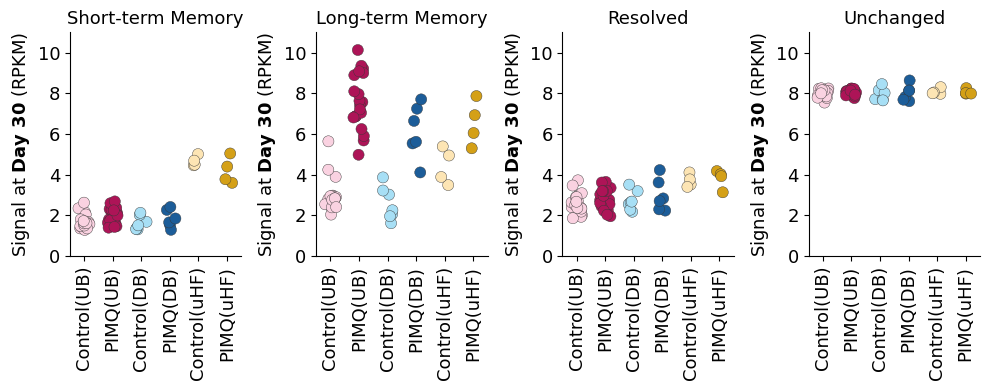

In [ ]:
# Plot per-category RPKM signal across celltype/condition groups
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the custom palette includes all condition/celltype combinations
condition_palette = {
    'Control_UB': '#AED9E0',
    'PIMQ_UB': '#117A8B',
    'Control_DB': '#FFE5A8',
    'PIMQ_DB': '#FF8F00',
    'Control_uHF': '#D1B3C4',
    'PIMQ_uHF': '#673AB7'
}

condition_palette = {
    'Control_UB': '#AED9E0',
    'PIMQ_UB': '#117A8B',
    'Control_DB': '#FDE5B4',
    'PIMQ_DB': '#D4A017',
    'Control_uHF': '#D1B3C4',
    'PIMQ_uHF': '#673AB7'
}

condition_palette = {
    'Control_UB': '#AED9E0',
    'PIMQ_UB': '#117A8B',
    'Control_DB': '#85C89F',
    'PIMQ_DB': '#087A3B',
    'Control_uHF': '#FDE5B4',
    'PIMQ_uHF': '#D4A017'
}
condition_palette = {
    'Control_UB': '#FAD2E1',
    'PIMQ_UB': '#AD1457',
    'Control_DB': '#A7DFF5',
    'PIMQ_DB': '#1C5D99',
    'Control_uHF': '#FDE5B4',
    'PIMQ_uHF': '#D4A017'
}

# Create a combined label "Condition_celltype"
rpkm_adata.obs['celltype_condition'] = rpkm_adata.obs['Condition'].astype(str) + '_' + rpkm_adata.obs['celltype'].astype(str)

# Plot settings
font_size = 13
dot_size = 6
box_width = 0.8

# Order on the x-axis to match the palette and desired display order
celltype_condition_order = [
    'Control_UB', 'PIMQ_UB',
    'Control_DB', 'PIMQ_DB',
    'Control_uHF', 'PIMQ_uHF'
]

# Columns to plot and panel titles
signal_columns = ['st_memory', 'lt_memory', 'resolved', 'unchanged']
panel_titles = ['Short-term Memory', 'Long-term Memory', 'Resolved', 'Unchanged']

# Create a 4-panel figure
fig, axes = plt.subplots(1, 4, figsize=(10, 4))

for i, signal_col in enumerate(signal_columns):
    #sns.boxplot(
    #    data=rpkm_adata.obs,
    #    x='celltype_condition',
    #    y=signal_col,
    #    palette=condition_palette,
    #    order=celltype_condition_order,
    #    width=box_width,
    #    ax=axes[i],
    #    linewidth=0.7,
    #    fliersize=0
    #)

    sns.stripplot(
        data=rpkm_adata.obs,
        x='celltype_condition',
        y=signal_col,
        palette=condition_palette,
        order=celltype_condition_order,
        size=dot_size+2,
        ax=axes[i],
        alpha=1,
        jitter=0.2,
        linewidth=0.3
    )

    axes[i].set_ylim(0, 11)
    axes[i].set_title(panel_titles[i], fontsize=font_size)
    axes[i].set_ylabel('Signal at $\\mathbf{Day\\ 30}$ (RPKM)', fontsize=font_size)
    axes[i].set_xlabel('', fontsize=font_size)
    axes[i].tick_params(axis='both', labelsize=font_size)

    # Set x-axis tick labels
    axes[i].set_xticklabels(
        ['Control(UB)', 'PIMQ(UB)', 'Control(DB)', 'PIMQ(DB)', 'Control(uHF)', 'PIMQ(uHF)'],
        rotation=90,
        fontsize=font_size
    )
plt.tight_layout()
plt.savefig("../pdf_plots/Y1_boxplot_bulk_memory.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# Imports (repeated) and plotting configuration for the bulk-signal vs number-of-cells analysis
import scanpy as sc
#from cellbender.remove_background.downstream import anndata_from_h5
import pandas as pd
import numpy as np
import scipy.sparse
import scipy.cluster.hierarchy as shc
from scipy import stats
from scipy.sparse import csr_matrix, hstack
import os
import anndata
import time
import SEACells
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import plot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import warnings
from scipy.stats import pearsonr, spearmanr
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['font.family'] = 'sans-serif' 

np.random.seed(1966)


In [ ]:
# Reload the normalized AnnData object (Year 1, non-redundant peak set)
import pickle
with open('../intermediate_outputs3/sc_data/Y1_nrpeakset.pickle', 'rb') as file:
    ad_norm = pickle.load(file)

In [ ]:
# Read BED files (local path) for peak categories used in the downstream heatmaps
bed_df = pd.read_table('/mnt/d/Projects/Fuchs/final_outs/whole/D30_short_memory.bed',
                       sep='\t', names = ['Chromosome', 'Start', 'End', 'A', 'B', 'C'] ,  header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
short_term_memory_peaks = bed_df['Name'].to_list()

bed_df = pd.read_table('/mnt/d/Projects/Fuchs/final_outs/whole/D30_resolved.bed', sep='\t', names = ['Chromosome', 'Start', 'End', 'A', 'B', 'C'] ,  header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
resolved_peaks = bed_df['Name'].to_list()


bed_df = pd.read_table('/mnt/d/Projects/Fuchs/final_outs/whole/unchanged_downsampled.bed', sep='\t', names = ['Chromosome', 'Start', 'End', 'A', 'B', 'C'] ,  header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
unchanged_peaks = bed_df['Name'].to_list()


bed_df = pd.read_table('/mnt/d/Projects/Fuchs/final_outs/whole/D30_M12_memory.bed', sep='\t', names = ['Chromosome', 'Start', 'End', 'A', 'B', 'C'] ,  header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
long_term_memory_peaks = bed_df['Name'].to_list()

bed_df = pd.read_table('/mnt/d/Projects/Fuchs/final_outs/whole/D30_all_memory.bed', sep='\t', names = ['Chromosome', 'Start', 'End', 'A', 'B', 'C'] ,  header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
all_memory_peaks = bed_df['Name'].to_list()


In [ ]:
# Create a DataFrame to annotate peaks with their memory categories (duplicate)
peak_info = pd.DataFrame({'Peak':  ad_norm.var_names})

peak_info['st_memory'] = 'No' 
peak_info['lt_memory'] = 'No' 
peak_info['resolved'] = 'No' 
peak_info['unchanged'] = 'No' 
peak_info['all_memory'] = 'No' 

peak_info.loc[peak_info['Peak'].isin(short_term_memory_peaks) , 'st_memory'] = 'Yes'
peak_info.loc[peak_info['Peak'].isin(resolved_peaks) , 'resolved'] = 'Yes'
peak_info.loc[peak_info['Peak'].isin(unchanged_peaks) , 'unchanged'] = 'Yes'
peak_info.loc[peak_info['Peak'].isin(long_term_memory_peaks) , 'lt_memory'] = 'Yes'
peak_info.loc[peak_info['Peak'].isin(all_memory_peaks) , 'all_memory'] = 'Yes'

# Function to determine the peak category
def determine_peak_category(row):
    if row['st_memory'] == 'Yes':
        return 'st_memory'
    elif row['resolved'] == 'Yes':
        return 'resolved'
    elif row['unchanged'] == 'Yes':
        return 'unchanged'
    elif row['lt_memory'] == 'Yes':
        return 'lt_memory'
    elif row['all_memory'] == 'Yes':
        return 'all_memory'
    else:
        return 'None'

peak_info['category'] = peak_info.apply(determine_peak_category, axis=1)

peak_info

,Peak,st_memory,lt_memory,resolved,unchanged,all_memory,category
0,chr1:3398919-3399472,No,No,No,No,No,None
1,chr1:3399879-3400446,No,No,No,No,No,None
2,chr1:3611112-3611678,No,No,No,No,No,None
3,chr1:3669618-3669932,No,No,No,No,No,None
4,chr1:3670476-3672673,No,No,No,No,No,None
...,...,...,...,...,...,...,...
219052,chrX:170004191-170004756,No,No,No,No,No,None
219053,chrX:170004818-170005872,No,No,No,No,No,None
219054,chrX:170673319-170673887,No,No,No,No,No,None
219055,chrX:170674212-170677851,No,No,No,No,No,None


# Heatmaps per peak category (short-term memory, long-term memory, resolved, unchanged)

In [ ]:
# Convert expression data to z-scores for heatmap visualization
zscore_expression = ad_norm.to_df()
zscore_expression = (zscore_expression - zscore_expression.mean()) / zscore_expression.std()

In [ ]:
# Reload the normalized AnnData object again to ensure a clean state
import pickle
with open('../intermediate_outputs3/sc_data/Y1_nrpeakset.pickle', 'rb') as file:
    ad_norm = pickle.load(file)

In [ ]:
# Define lists of SEACell names for each condition and cell type in Year 1
year1_control_ub_cells = list(ad_norm[ad_norm.obs['condition_celltype'] == 'Control_UB'].obs_names)
year1_control_db_cells = list(ad_norm[ad_norm.obs['condition_celltype'] == 'Control_DB'].obs_names)
year1_control_uhf_cells = list(ad_norm[ad_norm.obs['condition_celltype'] == 'Control_uHF'].obs_names)
year1_pimq_ub_cells = list(ad_norm[ad_norm.obs['condition_celltype'] == 'PIMQ_UB'].obs_names)
year1_pimq_db_cells = list(ad_norm[ad_norm.obs['condition_celltype'] == 'PIMQ_DB'].obs_names)
year1_pimq_uhf_cells = list(ad_norm[ad_norm.obs['condition_celltype'] == 'PIMQ_uHF'].obs_names)
print(len(year1_control_ub_cells + year1_pimq_ub_cells),
     len(year1_control_db_cells + year1_pimq_db_cells),
     len(year1_control_uhf_cells + year1_pimq_uhf_cells))

38 13 8


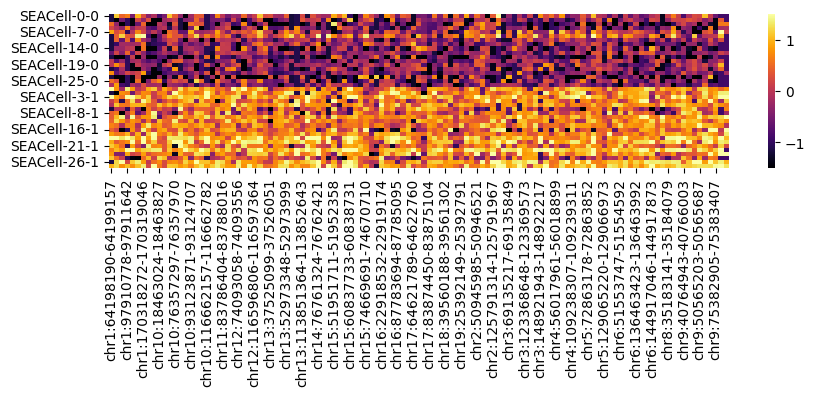

In [ ]:
# Generate heatmap for long-term memory peaks in UB cells
plt.figure(figsize=(116/11.6, 38/19))
peak_type = 'lt_memory'
sns.heatmap(zscore_expression.loc[year1_control_ub_cells + year1_pimq_ub_cells, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap = 'inferno',
           vmin = -1.5,
           vmax = 1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/Y1_heatmap_UB_LTmem.pdf", format="pdf", bbox_inches="tight")
plt.show()

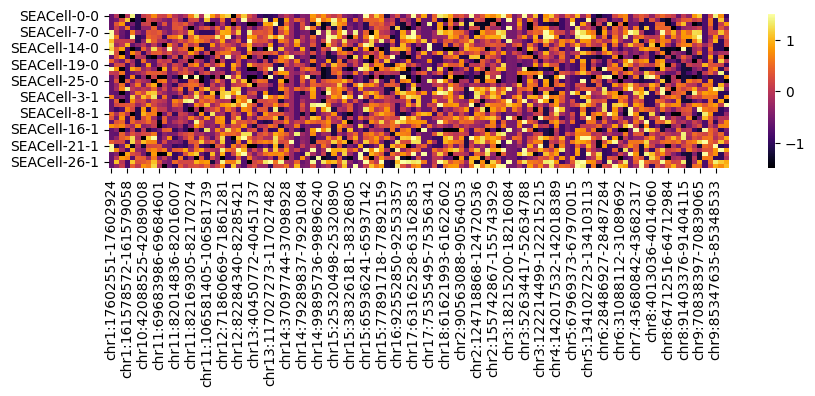

In [ ]:
# Generate heatmap for short-term memory peaks in UB cells
plt.figure(figsize=(116/11.6, 38/19))
peak_type = 'st_memory'
sns.heatmap(zscore_expression.loc[year1_control_ub_cells + year1_pimq_ub_cells, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap = 'inferno',
           vmin = -1.5,
           vmax = 1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/Y1_heatmap_UB_STmem.pdf", format="pdf", bbox_inches="tight")
plt.show()

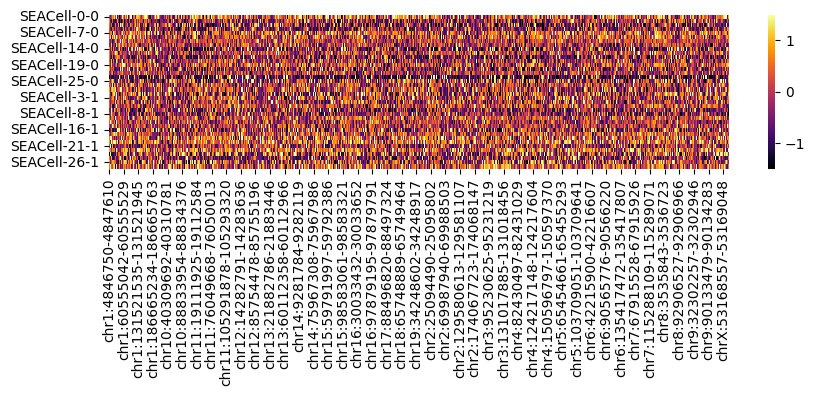

In [ ]:
# Generate heatmap for resolved peaks in UB cells
plt.figure(figsize=(116/11.6, 38/19))
peak_type = 'resolved'
sns.heatmap(zscore_expression.loc[year1_control_ub_cells + year1_pimq_ub_cells, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap = 'inferno',
           vmin = -1.5,
           vmax = 1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/Y1_heatmap_UB_RESOLVED.pdf", format="pdf", bbox_inches="tight")
plt.show()

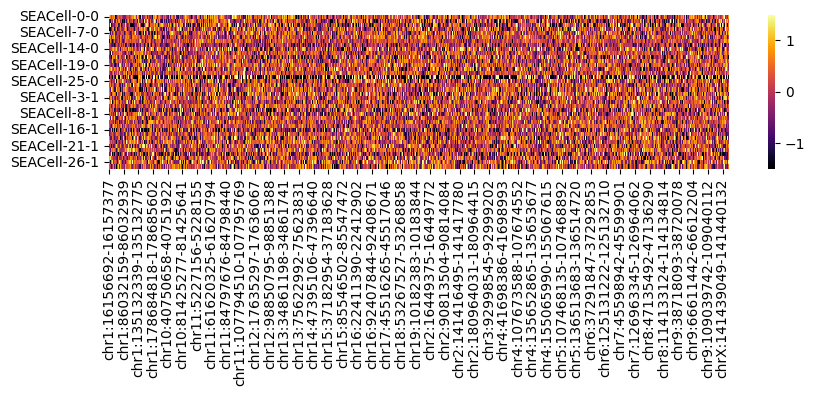

In [ ]:
# Generate heatmap for unchanged peaks in UB cells
plt.figure(figsize=(116/11.6, 38/19))
peak_type = 'unchanged'
sns.heatmap(zscore_expression.loc[year1_control_ub_cells + year1_pimq_ub_cells, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap = 'inferno',
           vmin = -1.5,
           vmax = 1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/Y1_heatmap_UB_UNCHANGED.pdf", format="pdf", bbox_inches="tight")
plt.show()

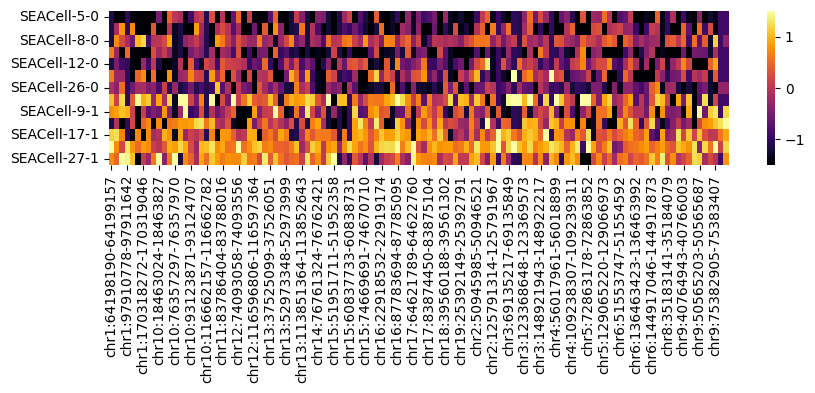

In [ ]:
# Generate heatmap for long-term memory peaks in DB cells
plt.figure(figsize=(116/11.6, 38/19))
peak_type = 'lt_memory'
sns.heatmap(zscore_expression.loc[year1_control_db_cells + year1_pimq_db_cells, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap = 'inferno',
           vmin = -1.5,
           vmax = 1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/Y1_heatmap_DB_LTmem.pdf", format="pdf", bbox_inches="tight")
plt.show()

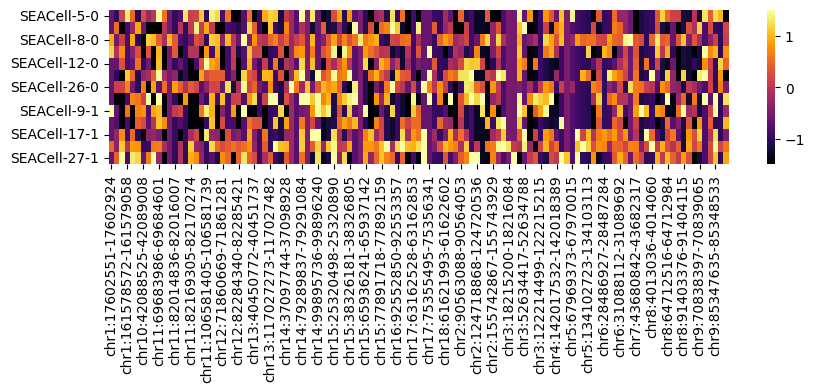

In [ ]:
# Generate heatmap for short-term memory peaks in DB cells
plt.figure(figsize=(116/11.6, 38/19))
peak_type = 'st_memory'
sns.heatmap(zscore_expression.loc[year1_control_db_cells + year1_pimq_db_cells, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap = 'inferno',
           vmin = -1.5,
           vmax = 1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/Y1_heatmap_DB_STmem.pdf", format="pdf", bbox_inches="tight")
plt.show()

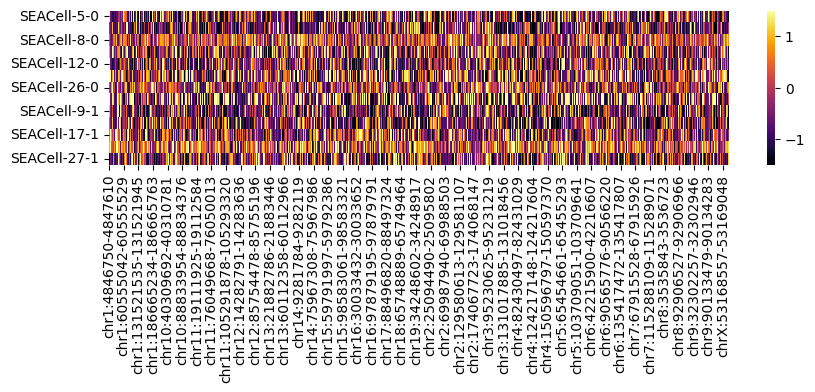

In [ ]:
# Generate heatmap for resolved peaks in DB cells
plt.figure(figsize=(116/11.6, 38/19))
peak_type = 'resolved'
sns.heatmap(zscore_expression.loc[year1_control_db_cells + year1_pimq_db_cells, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap = 'inferno',
           vmin = -1.5,
           vmax = 1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/Y1_heatmap_DB_RESOLVED.pdf", format="pdf", bbox_inches="tight")
plt.show()

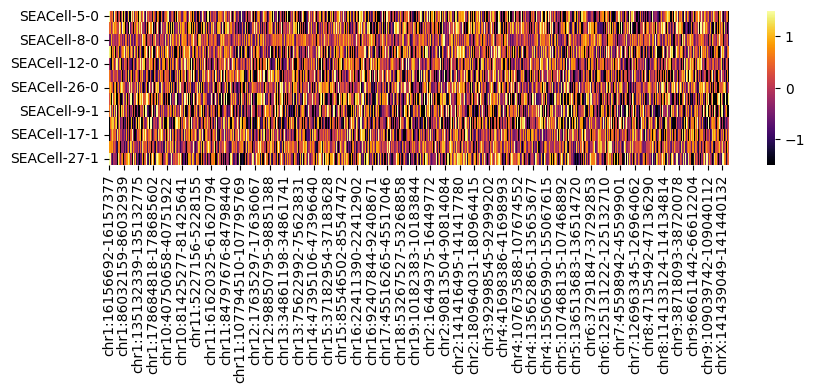

In [ ]:
# Generate heatmap for unchanged peaks in DB cells
plt.figure(figsize=(116/11.6, 38/19))
peak_type = 'unchanged'
sns.heatmap(zscore_expression.loc[year1_control_db_cells + year1_pimq_db_cells, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap = 'inferno',
           vmin = -1.5,
           vmax = 1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/Y1_heatmap_DB_UNCHANGED.pdf", format="pdf", bbox_inches="tight")
plt.show()

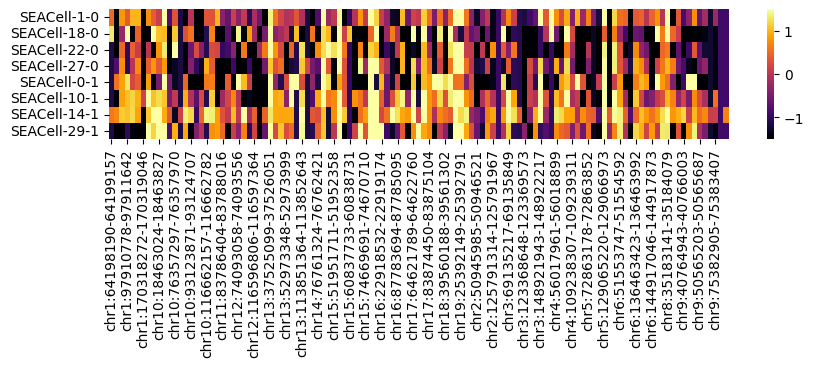

In [ ]:
# Generate heatmap for long-term memory peaks in uHF cells
plt.figure(figsize=(116/11.6, 32/19))
peak_type = 'lt_memory'
sns.heatmap(zscore_expression.loc[year1_control_uhf_cells + year1_pimq_uhf_cells, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap = 'inferno',
           vmin = -1.5,
           vmax = 1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/Y1_heatmap_UHF_LTmem.pdf", format="pdf", bbox_inches="tight")
plt.show()

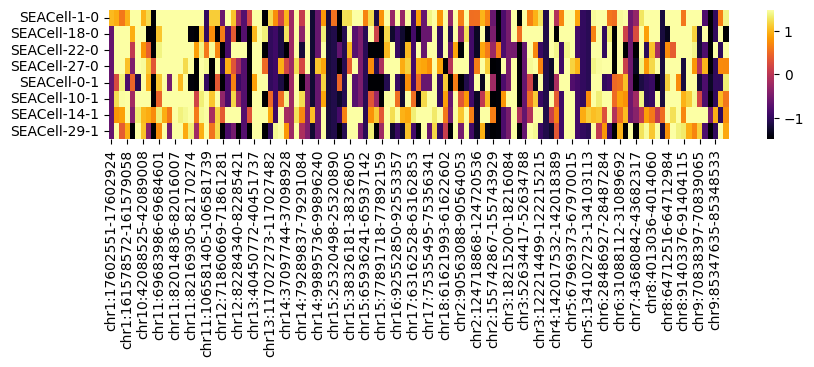

In [ ]:
# Generate heatmap for short-term memory peaks in uHF cells
plt.figure(figsize=(116/11.6, 32/19))
peak_type = 'st_memory'
sns.heatmap(zscore_expression.loc[year1_control_uhf_cells + year1_pimq_uhf_cells, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap = 'inferno',
           vmin = -1.5,
           vmax = 1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/Y1_heatmap_UHF_STmem.pdf", format="pdf", bbox_inches="tight")
plt.show()

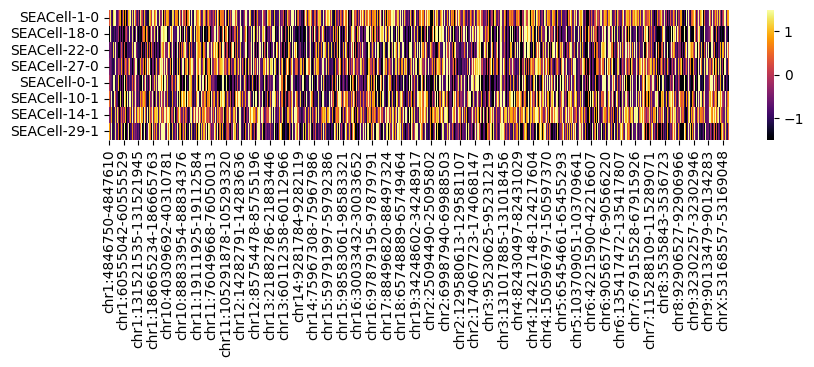

In [ ]:
# Generate heatmap for resolved peaks in uHF cells
plt.figure(figsize=(116/11.6, 32/19))
peak_type = 'resolved'
sns.heatmap(zscore_expression.loc[year1_control_uhf_cells + year1_pimq_uhf_cells, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap = 'inferno',
           vmin = -1.5,
           vmax = 1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/Y1_heatmap_UHF_RESOLVED.pdf", format="pdf", bbox_inches="tight")
plt.show()

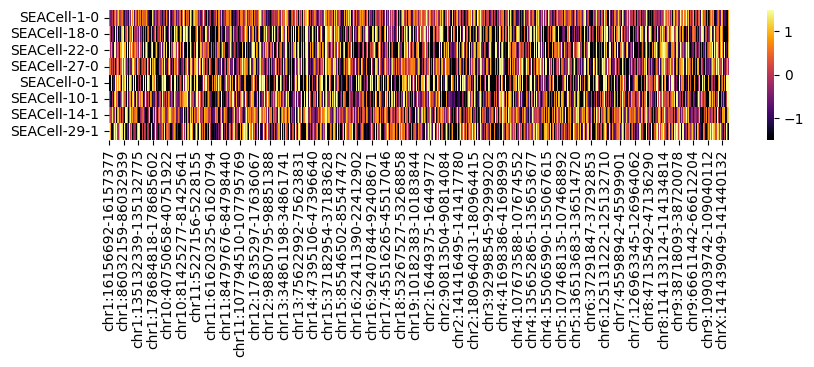

In [ ]:
# Generate heatmap for unchanged peaks in uHF cells
plt.figure(figsize=(116/11.6, 32/19))
peak_type = 'unchanged'
sns.heatmap(zscore_expression.loc[year1_control_uhf_cells + year1_pimq_uhf_cells, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap = 'inferno',
           vmin = -1.5,
           vmax = 1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/Y1_heatmap_UHF_UNCHANGED.pdf", format="pdf", bbox_inches="tight")
plt.show()